In [9]:
%matplotlib inline

from scipy.misc     import imsave
from keras          import metrics
from PIL            import Image

from keras.models                import Model
from keras.applications.vgg16    import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16    import decode_predictions
from keras.utils.np_utils        import to_categorical

import keras.backend     as K
import numpy             as np
import matplotlib.pyplot as plt

import os

In [10]:
import warnings

warnings.filterwarnings('ignore')

In [11]:
def limit_mem():
    cfg                          = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config = cfg))

In [12]:
limit_mem()

In [13]:
folder = 'images/'

# Goal

The goal of this notebook is to implement the "targeted fast gradient sign method" presented in [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572). This method is used to modify classical samples that a deep neural network trained classification will fail to classify properly.

![fgsm idea](http://karpathy.github.io/assets/break/breakconv.png "Fast Gradient Sign Method")

The idea of this method is to take a sample, ask the network to classify it, compute the gradient of the loss regarding the least probable class in function of the input pixels and update the picture by a small amount in the opposite direction of the gradient. This direction is towards a wrong class and thus sensible to cause an error in the classification.

# Adversarial example generation

This notebook presents a factorized version of the generation process. For a step-by-step explanation, see the other notebook in this repository.

In [6]:
imagenet_mean = np.array([123.68, 116.779, 103.939], dtype = np.float32)
preprocess    = lambda x: (x - imagenet_mean)[:, :, :, ::-1]
deprocess     = lambda x: (x[:, :, :, ::-1] + imagenet_mean)

def get_gradient_signs(model, original_array):
    target_idx      = model.predict(original_array).argmin()
    target          = to_categorical(target_idx, 1000)
    target_variable = K.variable(target)
    loss            = metrics.categorical_crossentropy(model.output, target_variable)
    gradients       = K.gradients(loss, model.input)
    get_grad_values = K.function([model.input], gradients)
    grad_values     = get_grad_values([original_array])[0]
    grad_signs      = np.sign(grad_values)
    
    return grad_signs
    
def pertubate_image(preprocessed_array, perturbation):
    modified_array  = preprocessed_array - perturbation
    deprocess_array = np.clip(deprocess(modified_array), 0., 255.).astype(np.uint8)
    
    return deprocess_array

def generate_titles(display_model, preprocessed_array, perturbation, modified_array):
    title_original     = generate_title(display_model, preprocessed_array)
    title_perturbation = generate_title(display_model, perturbation)
    title_modified     = generate_title(display_model, modified_array)
    
    return title_original, title_perturbation, title_modified

def generate_adversarial_example(pertubation_model, original_array, epsilon):
    gradient_signs = get_gradient_signs(pertubation_model, original_array)
    perturbation   = gradient_signs * epsilon
    modified_image = pertubate_image(original_array, perturbation)
    
    return modified_image, perturbation

def load_image(filename):
    original_pic   = Image.open(filename).resize((224, 224))
    original_array = np.expand_dims(np.array(original_pic), 0)

    return original_array
    
def create_title(category, proba):
    return '"%s" %.1f%% confidence' % (category.replace('_', ' '), proba * 100) 

def generate_title(model, array):
    prediction = model.predict(array)
    _, category, proba = decode_predictions(prediction)[0][0]
    
    return create_title(category, proba)
    
def generate_adversarial_examples(folder, title, perturbation_model, display_model = None, epsilon = 5):
    if not display_model:
        display_model = perturbation_model

    filenames   = os.listdir(folder)
    line_number = len(filenames)
    plt.figure(figsize = (15, 10 * line_number))
    
    for line, filename in enumerate(filenames):
        original_array               = load_image(folder + filename)
        preprocessed_array           = preprocess(original_array)    
        modified_image, perturbation = generate_adversarial_example(perturbation_model, preprocessed_array, epsilon)
        preprocess_modified          = preprocess(modified_image)
        orig_tit, pert_tit, modi_tit = generate_titles(display_model, preprocessed_array, perturbation, preprocess_modified)

        plt.subplot(line_number, 3, 3 * line + 1)
        plt.imshow(original_array[0])
        plt.title(orig_tit)
        plt.subplot(line_number, 3, 3 * line + 2)
        plt.imshow(perturbation[0])
        plt.title(pert_tit)
        plt.subplot(line_number, 3, 3 * line + 3)
        plt.imshow(modified_image[0])
        plt.title(modi_tit)
        
    plt.suptitle(title)
    plt.tight_layout(pad = 4)

In [7]:
vgg16    = VGG16()

In the following figures, the left column contains the original images, the middle one the perturbation and the right one the generated adversarial sample. The result of the classification is displayed above each image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

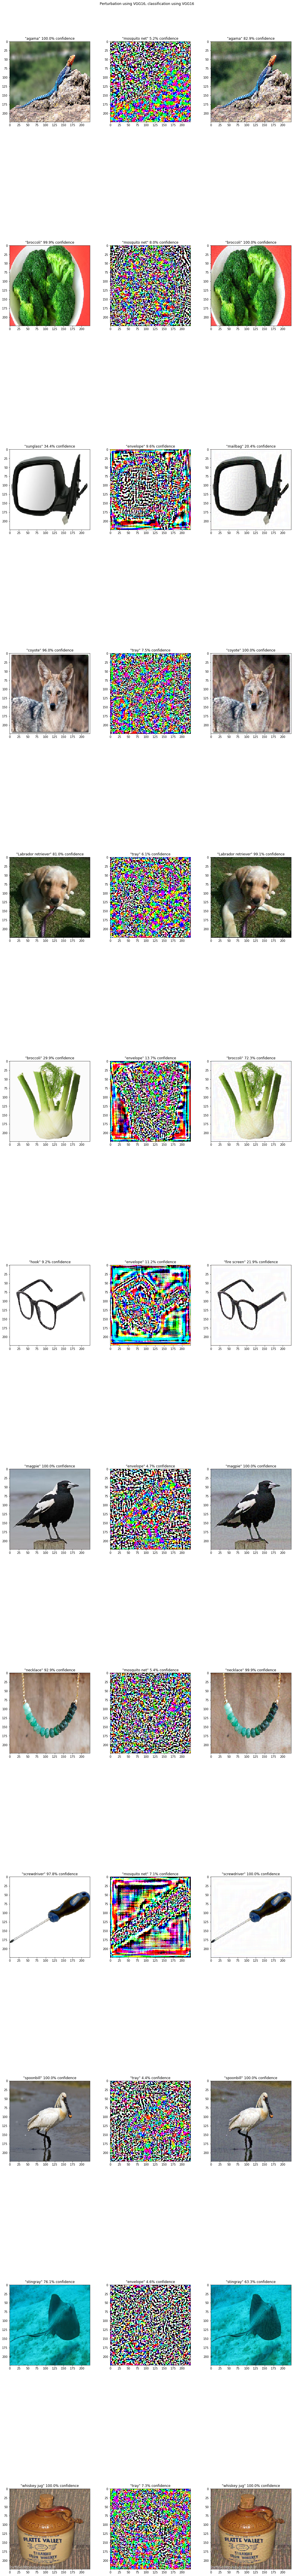

In [8]:
generate_adversarial_examples(folder, 'Perturbation using VGG16, classification using VGG16', perturbation_model = vgg16, display_model = vgg16)

Using the targeted Fast Gradient Sign Method allows us to generate new images from existing samples that the network will classify as the targeted class. This method seems to be less effective at creating adversarial samples than traditional FGSM.